In [21]:
!pip install -q datasets sentence-transformers scikit-learn pandas numpy

import numpy as np
import pandas as pd
import random
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datasets import load_dataset

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
DEVICE = "cuda"

In [25]:
mmlu = load_dataset("cais/mmlu", "all")

# 4 VERY DIFFERENT topics
TOPICS = [
    "abstract_algebra",        # Math
    "anatomy",                 # Medical
    "world_religions",         # Religion
    "computer_security",       # CS
    "astronomy",               # Space/Physics
    "international_law",       # Law
    "marketing",               # Business
    "high_school_geography",   # Geography
    "philosophy",              # Philosophy
    "electrical_engineering",  # Engineering
]

# Sample 150 per topic
samples = []
for topic in TOPICS:
    topic_samples = [x for x in mmlu["test"] if x["subject"] == topic]
    samples.extend(random.sample(topic_samples, min(150, len(topic_samples))))

random.shuffle(samples)
print(f"Total: {len(samples)} samples")
for t in TOPICS:
    print(f"  {t}: {sum(1 for s in samples if s['subject'] == t)}")

Total: 1351 samples
  abstract_algebra: 100
  anatomy: 135
  world_religions: 150
  computer_security: 100
  astronomy: 150
  international_law: 121
  marketing: 150
  high_school_geography: 150
  philosophy: 150
  electrical_engineering: 145


In [26]:
embedder = SentenceTransformer("thenlper/gte-base", device=DEVICE)

texts = [s["question"] for s in samples]
embeddings = embedder.encode(texts, show_progress_bar=True, batch_size=64, normalize_embeddings=True)

print(f"Embeddings: {embeddings.shape}")

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Embeddings: (1351, 768)


In [27]:
import hdbscan

results = []

# KMeans
print("KMeans:")
for k in range(2, 10):
    labels = KMeans(n_clusters=k, random_state=SEED, n_init=10).fit_predict(embeddings)
    sil = silhouette_score(embeddings, labels, metric='cosine')
    results.append({"algo": "KMeans", "k": k, "silhouette": sil})
    print(f"  K={k}: {sil:.4f}")

# HDBSCAN
print("\nHDBSCAN:")
for min_cluster_size in [15, 25, 40, 60]:
    for min_samples in [5, 10]:
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric='euclidean'
        )
        labels = clusterer.fit_predict(embeddings)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = (labels == -1).sum()

        if n_clusters >= 2 and (labels != -1).sum() > n_clusters:
            mask = labels != -1
            sil = silhouette_score(embeddings[mask], labels[mask], metric='cosine')
        else:
            sil = -1

        results.append({
            "algo": "HDBSCAN",
            "k": n_clusters,
            "silhouette": sil,
            "params": f"mcs={min_cluster_size}, ms={min_samples}",
            "noise": n_noise
        })
        print(f"  mcs={min_cluster_size}, ms={min_samples}: K={n_clusters}, noise={n_noise}, sil={sil:.4f}")

# Best result
df_results = pd.DataFrame(results)
best = df_results.loc[df_results['silhouette'].idxmax()]
print(f"\n🏆 BEST: {best['algo']} K={best['k']}, Silhouette={best['silhouette']:.4f}")

KMeans:
  K=2: 0.0682
  K=3: 0.0648
  K=4: 0.0783
  K=5: 0.0878
  K=6: 0.0953
  K=7: 0.1001
  K=8: 0.1025
  K=9: 0.1086

HDBSCAN:


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  mcs=15, ms=5: K=7, noise=926, sil=0.2072


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  mcs=15, ms=10: K=7, noise=1084, sil=0.2448


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  mcs=25, ms=5: K=7, noise=926, sil=0.2072


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  mcs=25, ms=10: K=6, noise=1104, sil=0.2441


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  mcs=40, ms=5: K=6, noise=962, sil=0.2117


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  mcs=40, ms=10: K=0, noise=1351, sil=-1.0000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  mcs=60, ms=5: K=3, noise=1127, sil=0.2365


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  mcs=60, ms=10: K=0, noise=1351, sil=-1.0000

🏆 BEST: HDBSCAN K=7, Silhouette=0.2448


In [29]:
# Get best config
best_algo = best['algo']
best_k = int(best['k'])

if best_algo == "KMeans":
    labels = KMeans(n_clusters=best_k, random_state=SEED, n_init=10).fit_predict(embeddings)
else:
    # Parse HDBSCAN params from string "mcs=X, ms=Y"
    params = best['params']
    mcs = int(params.split(',')[0].split('=')[1])
    ms = int(params.split(',')[1].split('=')[1])
    labels = hdbscan.HDBSCAN(
        min_cluster_size=mcs,
        min_samples=ms,
        metric='euclidean'
    ).fit_predict(embeddings)

# Compute centroids (exclude noise for HDBSCAN)
unique_labels = sorted(set(labels) - {-1})
centroids = np.array([embeddings[labels == i].mean(axis=0) for i in unique_labels])

# Save
np.save("centroids.npy", centroids)
np.save("embeddings.npy", embeddings)
np.save("labels.npy", labels)

# Save data
df = pd.DataFrame({
    "question": [s["question"] for s in samples],
    "subject": [s["subject"] for s in samples],
    "answer": [s["answer"] for s in samples],
    "cluster": labels
})
df.to_csv("mmlu_clustered.csv", index=False)

print(f"✅ Saved centroids, embeddings, labels, mmlu_clustered.csv")
print(f"   Centroids shape: {centroids.shape}")
print(f"   Noise samples: {(labels == -1).sum()}")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Saved centroids, embeddings, labels, mmlu_clustered.csv
   Centroids shape: (7, 768)
   Noise samples: 1084


In [30]:
import json

# Group questions by cluster
evaluation_data = {
    "metadata": {
        "best_algo": best_algo,
        "best_k": best_k,
        "silhouette": float(best['silhouette']),
        "total_samples": len(samples),
        "topics": TOPICS
    },
    "clusters": {}
}

for cluster_id in unique_labels:
    cluster_mask = labels == cluster_id
    cluster_samples = [s for s, m in zip(samples, cluster_mask) if m]

    # Subject distribution in this cluster
    subjects = [s["subject"] for s in cluster_samples]
    subject_counts = {t: subjects.count(t) for t in set(subjects)}

    evaluation_data["clusters"][str(cluster_id)] = {
        "n_samples": len(cluster_samples),
        "subject_distribution": subject_counts,
        "questions": [
            {
                "id": i,
                "question": s["question"],
                "choices": s["choices"],
                "answer": s["answer"],  # 0, 1, 2, or 3
                "subject": s["subject"]
            }
            for i, s in enumerate(cluster_samples)
        ]
    }

# Save JSON
with open("evaluation_data.json", "w") as f:
    json.dump(evaluation_data, f, indent=2)

print("✅ Saved: evaluation_data.json")
print(f"\nStructure:")
print(f"  Clusters: {len(unique_labels)}")
for cid in unique_labels:
    c = evaluation_data["clusters"][str(cid)]
    print(f"  Cluster {cid}: {c['n_samples']} questions")
    for subj, cnt in c["subject_distribution"].items():
        print(f"    - {subj}: {cnt}")

✅ Saved: evaluation_data.json

Structure:
  Clusters: 7
  Cluster 0: 27 questions
    - high_school_geography: 2
    - world_religions: 25
  Cluster 1: 34 questions
    - electrical_engineering: 34
  Cluster 2: 20 questions
    - electrical_engineering: 1
    - astronomy: 19
  Cluster 3: 29 questions
    - international_law: 29
  Cluster 4: 25 questions
    - philosophy: 25
  Cluster 5: 98 questions
    - computer_security: 11
    - international_law: 3
    - abstract_algebra: 81
    - marketing: 1
    - astronomy: 2
  Cluster 6: 34 questions
    - computer_security: 2
    - marketing: 32


Running UMAP 2D...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



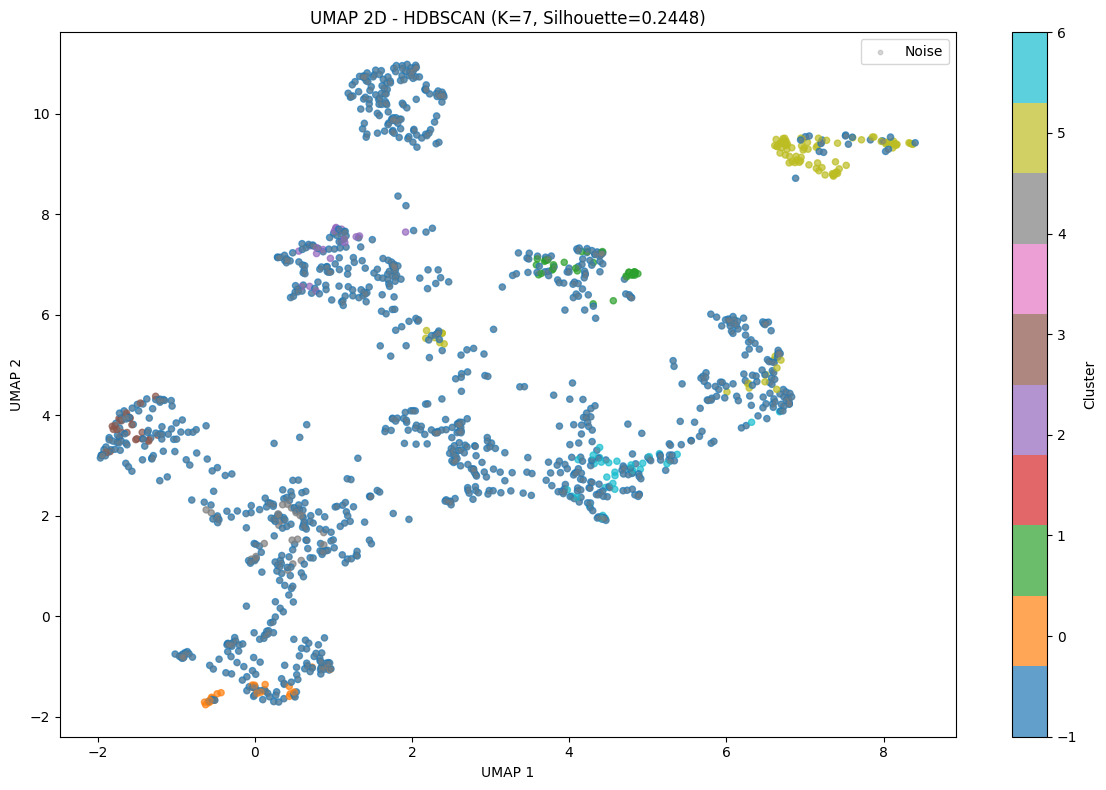

✅ Saved: clusters_2d.png


In [32]:
!pip install -q umap-learn plotly matplotlib

import umap
import plotly.express as px
import matplotlib.pyplot as plt

# ============================================================
# UMAP 2D
# ============================================================
print("Running UMAP 2D...")
umap_2d = umap.UMAP(n_components=2, random_state=SEED, n_neighbors=15, min_dist=0.1)
emb_2d = umap_2d.fit_transform(embeddings)

# Plot 2D with matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=labels,
    cmap='tab10',
    alpha=0.7,
    s=20
)
plt.colorbar(scatter, label='Cluster')
plt.title(f'UMAP 2D - {best_algo} (K={best_k}, Silhouette={best["silhouette"]:.4f})')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Mark noise if HDBSCAN
if -1 in labels:
    noise_mask = labels == -1
    plt.scatter(emb_2d[noise_mask, 0], emb_2d[noise_mask, 1], c='gray', s=10, alpha=0.3, label='Noise')
    plt.legend()

plt.tight_layout()
plt.savefig('clusters_2d.png', dpi=150)
plt.show()
print("✅ Saved: clusters_2d.png")





In [33]:
# ============================================================
# UMAP 3D
# ============================================================
print("\nRunning UMAP 3D...")
umap_3d = umap.UMAP(n_components=3, random_state=SEED, n_neighbors=15, min_dist=0.1)
emb_3d = umap_3d.fit_transform(embeddings)

# Create dataframe for plotly
plot_df = pd.DataFrame({
    'x': emb_3d[:, 0],
    'y': emb_3d[:, 1],
    'z': emb_3d[:, 2],
    'cluster': labels.astype(str),
    'subject': [s["subject"] for s in samples],
    'question': [s["question"][:80] + "..." for s in samples]
})

# Interactive 3D plot
fig = px.scatter_3d(
    plot_df,
    x='x', y='y', z='z',
    color='cluster',
    hover_data=['subject', 'question'],
    title=f'UMAP 3D - {best_algo} (K={best_k}, Silhouette={best["silhouette"]:.4f})',
    opacity=0.7,
    height=700
)
fig.update_traces(marker=dict(size=4))
fig.show()


Running UMAP 3D...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



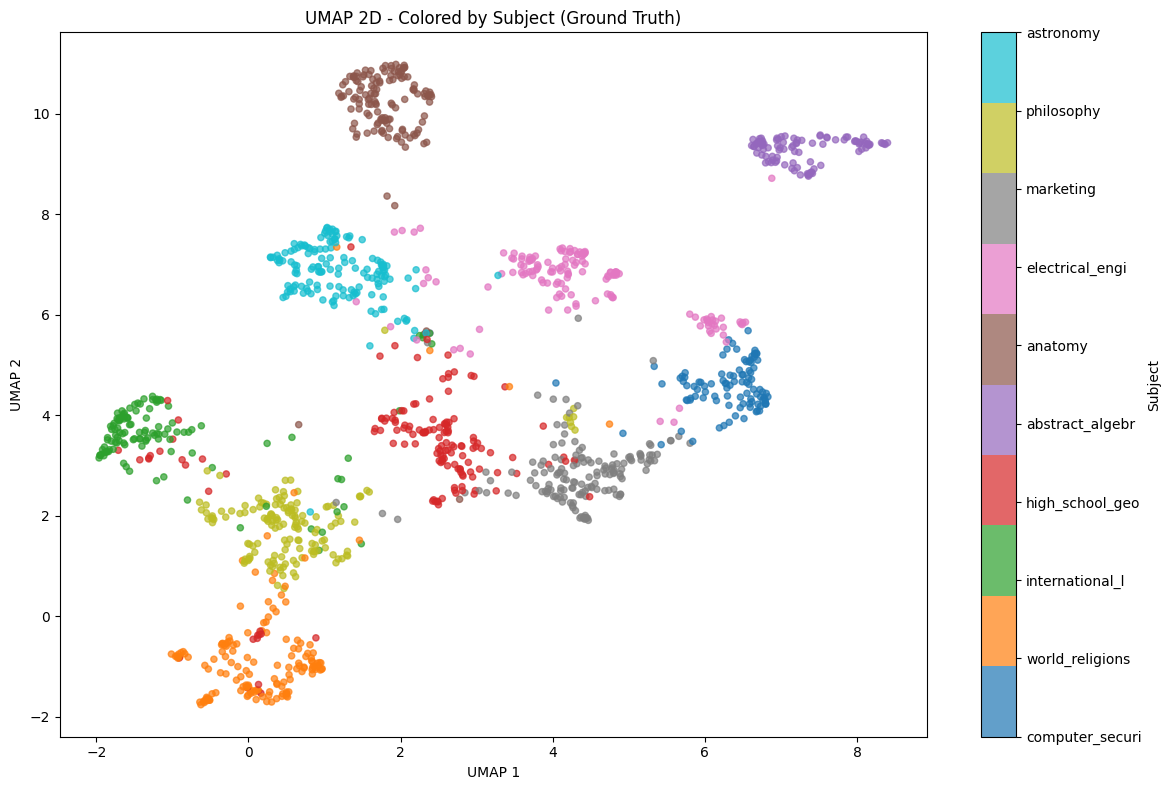

✅ Saved: subjects_2d.png


In [34]:
# ============================================================
# 2D colored by SUBJECT (to compare with clusters)
# ============================================================
plt.figure(figsize=(12, 8))
subjects = [s["subject"] for s in samples]
unique_subjects = list(set(subjects))
colors = [unique_subjects.index(s) for s in subjects]

scatter = plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=colors,
    cmap='tab10',
    alpha=0.7,
    s=20
)
cbar = plt.colorbar(scatter, label='Subject')
cbar.set_ticks(range(len(unique_subjects)))
cbar.set_ticklabels([s[:15] for s in unique_subjects])
plt.title('UMAP 2D - Colored by Subject (Ground Truth)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
plt.savefig('subjects_2d.png', dpi=150)
plt.show()
print("✅ Saved: subjects_2d.png")